In [25]:
#Expand notebook to take full screen width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

#Jupyter magic to notify when a cell finishes execution with %%notify command -- does not work with Jupyterlab
import jupyternotify
ip = get_ipython()
ip.register_magics(jupyternotify.JupyterNotifyMagics)

<IPython.core.display.Javascript object>

In [26]:
import gc

def memReport():
    for obj in gc.get_objects():
        if torch.is_tensor(obj):
            print(type(obj), obj.size())

In [40]:
#extract and save targets
layer_targets = model.kd_layer_targets(test_data_full, T=3).keys()
for targets in layer_targets:
    print (targets)

fc1
conv1
fc2
conv2


In [43]:
layer_targets['fc1']

TypeError: 'dict_keys' object is not subscriptable

In [27]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from torch.nn.modules import Module
from torch.autograd import Variable
import torch.nn.functional as F
import numpy as np
import IPython.display as ipd
import imageio
import copy
from tensorboardX import SummaryWriter
import pickle 

writeTensorboard = False
if(writeTensorboard):
    writer = SummaryWriter('tensorboard/run1/')

import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
sns.set(color_codes=True)
sns.set_style("whitegrid")

model_dir = "./models/"
import models
from plot_utils import show_sws_weights, show_weights, print_dims, prune_plot, draw_sws_graphs, joint_plot
from model_utils import test_accuracy, train_epoch, retrain_sws_epoch, model_prune, get_weight_penalty
from helpers import trueAfterN, logsumexp
from sws_utils import GaussianMixturePrior, special_flatten, KL, compute_responsibilies, merger, sws_prune

#Data
train_dataset = dsets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = dsets.MNIST(root='./data', train=False , transform=transforms.ToTensor(), download=True)
#train_dataset.train_labels = train_dataset.train_labels.float()
#test_dataset.test_labels = test_dataset.test_labels.float()

In [28]:
batch_size = 256
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
train_data_full = Variable(train_dataset.train_data.float()/255.0).cuda()
test_data_full = Variable(test_dataset.test_data.float()/255.0).cuda()
train_labels_full = Variable(train_dataset.train_labels).cuda()
test_labels_full = Variable(test_dataset.test_labels).cuda()

#arguments
#model_name = 'LeNet_300_100'
training_epochs=100
#retraining_epochs=50
#temp_list = [1, 5, 10, 15, 20, 25, 30]

In [29]:
#4D tensor fix for conv-netpyth
test_data_full = test_data_full.view(10000, 1, 28, 28)
train_data_full = train_data_full.view(60000, 1, 28, 28)
model_name = 'SWSModel'

### 2. Re-train Model with GMM Constraints

temp = 8
model = torch.load(model_dir + 'mnist_{}_{}.m'.format(model_name, training_epochs)).cuda()
kd_outputs = model.kd_targets(train_data_full,T=temp)
kd_dataset = torch.utils.data.TensorDataset(train_data_full.data, kd_outputs.data)#.data turns variable -> tensor
train_kd_loader = torch.utils.data.DataLoader(dataset=kd_dataset, batch_size=batch_size, shuffle=True)

In [4]:
model = torch.load(model_dir + 'mnist_{}_{}.m'.format(model_name, training_epochs)).cuda()
kd_outputs = model.kd_layer_targets(train_data_full)

/anaconda/envs/py35/lib/python3.5/site-packages/torch/serialization.py:325: SourceChangeWarning: source code of class 'models.SWSModel' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


In [ ]:
%%notify

alpha, beta = (25000, 10)
model_retrain = torch.load(model_dir + 'mnist_{}_{}.m'.format(model_name, training_epochs)).cuda()
gmp = GaussianMixturePrior(16, [x for x in model_retrain.parameters()], 0.99, ab = (alpha, beta))

test_acc = test_accuracy(test_data_full, test_labels_full, model_retrain)
train_acc = test_accuracy(train_data_full, train_labels_full, model_retrain)
acc_history = np.array([train_acc[0], test_acc[0]])
stddev_history = np.sqrt(1. / gmp.gammas.exp().data.clone().cpu().numpy())
mean_history = gmp.means.data.clone().cpu().numpy()
mixprop_history = gmp.rhos.exp().data.clone().cpu().numpy()

sws_param1 = [gmp.means]
sws_param2 = [gmp.gammas, gmp.rhos]
#ipd.display(ipd.Markdown("**Default Training**"))

criterion = nn.MSELoss()
learning_rate_kd = 1e-4
optimizer_kd_1 = torch.optim.Adam(model_retrain.conv1.parameters(), lr=learning_rate_kd)
optimizer_kd_2 = torch.optim.Adam(model_retrain.conv2.parameters(), lr=learning_rate_kd)
optimizer_kd_3 = torch.optim.Adam(model_retrain.fc1.parameters(), lr=learning_rate_kd)
optimizer_kd_4 = torch.optim.Adam(model_retrain.fc2.parameters(), lr=learning_rate_kd)
#criterion = nn.CrossEntropyLoss()
#optimizer = torch.optim.Adam(model_retrain.parameters(), lr=1e-4)
optimizer_gmp1 = torch.optim.Adam(sws_param1, lr=1e-4)
optimizer_gmp2 = torch.optim.Adam(sws_param2, lr=3e-3)
graph_title='retrain_model/'

retraining_epochs = 40
decay = np.linspace(5e-7, 5e-6, retraining_epochs)
#decay = 5e-7 * np.power(10, decay)
#decay = 5e-5 * (1 - 1 / np.power(10, decay))

exp_name = "kd_m{}_a{}_b{}_r{}".format(model_retrain.name, alpha, beta, retraining_epochs)

for epoch in range(retraining_epochs):
    ipd.display(ipd.Markdown("**Epoch: {}**".format(epoch+1)))
    #tau = float(decay[epoch])
    tau=5e-6
    #model_retrain, loss = retrain_sws_epoch(model_retrain, gmp, optimizer, optimizer_gmp1, optimizer_gmp2, criterion, train_loader, tau)
    model_retrain, loss = retrain_sws_epoch(model_retrain, gmp, optimizer_kd_1, optimizer_gmp1, optimizer_gmp2, criterion, train_kd_loader, tau)
    model_retrain, loss = retrain_sws_epoch(model_retrain, gmp, optimizer_kd_2, optimizer_gmp1, optimizer_gmp2, criterion, train_kd_loader, tau)
    model_retrain, loss = retrain_sws_epoch(model_retrain, gmp, optimizer_kd_3, optimizer_gmp1, optimizer_gmp2, criterion, train_kd_loader, tau)
    model_retrain, loss = retrain_sws_epoch(model_retrain, gmp, optimizer_kd_4, optimizer_gmp1, optimizer_gmp2, criterion, train_kd_loader, tau)

    test_acc = test_accuracy(test_data_full, test_labels_full, model_retrain)
    train_acc = test_accuracy(train_data_full, train_labels_full, model_retrain)
    weight_penalty = get_weight_penalty(model_retrain)

    stddev_history = np.vstack((stddev_history,  np.sqrt(1. / gmp.gammas.exp().data.clone().cpu().numpy()) ))
    mean_history = np.vstack((mean_history, gmp.means.data.clone().cpu().numpy() ))
    mixprop_history = np.vstack((mixprop_history, gmp.rhos.exp().data.clone().cpu().numpy() ))
    acc_history = np.vstack(( acc_history, np.array([train_acc[0], test_acc[0]]) ))

    if(writeTensorboard):
        writer.add_scalars(graph_title + 'CrossEntropyLoss', {'Test': test_acc[1], 'Train': train_acc[1]}, epoch+1)
        writer.add_scalars(graph_title + 'Accuracy', {'Test': test_acc[0], 'Train': train_acc[0]}, epoch+1)
        writer.add_scalars(graph_title + 'L2', {'L2' : weight_penalty}, epoch+1)
        for name, param in model_retrain.named_parameters():
            writer.add_histogram(graph_title + name, param.clone().cpu().data.numpy(), epoch+1, bins='doane')
    if (trueAfterN(epoch, 10)):
        gmp.print_batch = True
        print ('Tau:{}'.format(tau))
        print('Epoch: {}. Training Accuracy: {:.2f}. Test Accuracy: {}'.format(epoch+1, train_acc[0], test_acc[0]))
        print ( "Means: {}".format(list(np.around(gmp.means.data.clone().cpu().numpy(),3))) )
        print ( "Mixing Proportions: {}".format(list(np.around(gmp.rhos.data.clone().cpu().numpy(),3))) )
        print ( "Precisions: {}".format(list(np.around(gmp.gammas.data.clone().cpu().numpy(),3))) )
    show_sws_weights(model = model_retrain, means = list(gmp.means.data.clone().cpu()), precisions = list(gmp.gammas.data.clone().cpu()), epoch = epoch, accuracy = test_acc[0], savefile = exp_name)
    joint_plot(model_retrain, model, gmp, epoch, retraining_epochs, test_acc[0], savefile = exp_name)
        #show_all_weights(model_retrain)

/anaconda/envs/py35/lib/python3.5/site-packages/torch/serialization.py:325: SourceChangeWarning: source code of class 'models.SWSModel' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 2500.0 Variance: 250.0


**Epoch: 1**

Layer Loss: 615.152
Layer Loss: 14.212
Layer Loss: 8181.761
Layer Loss: 26.018
Layer Loss: 367156.969
Layer Loss: 247.160
Layer Loss: 3322.494
Layer Loss: 5.680
0-neglogprop Loss: -13828.171
Remaining-neglogprop Loss: -1037279.125


**Epoch: 2**

**Epoch: 3**

**Epoch: 4**

**Epoch: 5**

**Epoch: 6**

**Epoch: 7**

**Epoch: 8**

**Epoch: 9**

**Epoch: 10**

Tau:5e-06
Epoch: 10. Training Accuracy: 97.66. Test Accuracy: 97.35
Means: [-0.563, -0.739, -0.266, -0.351, -0.275, -0.077, -0.073, -0.056, 0.047, 0.119, 0.229, 0.076, 0.457, 0.727, 0.725]
Mixing Proportions: [-6.404, -10.583, -4.777, -16.515, -16.384, -3.096, -15.04, -15.08, -15.286, -16.213, -5.445, -3.679, -7.655, -17.117, -12.724]
Precisions: [11.91, 7.846, 7.824, 7.93, 7.824, 7.824, 8.296, 7.824, 7.824, 7.824, 7.824, 7.871, 8.101, 7.829, 7.824, 7.824]


**Epoch: 11**

Layer Loss: 1493.655
Layer Loss: -4.762
Layer Loss: -13743.744
Layer Loss: -150.884
Layer Loss: -1851048.750
Layer Loss: -2053.107
Layer Loss: -2131.817
Layer Loss: -13.371
0-neglogprop Loss: 237921.188
Remaining-neglogprop Loss: -2554386.750


**Epoch: 12**

**Epoch: 13**

**Epoch: 14**

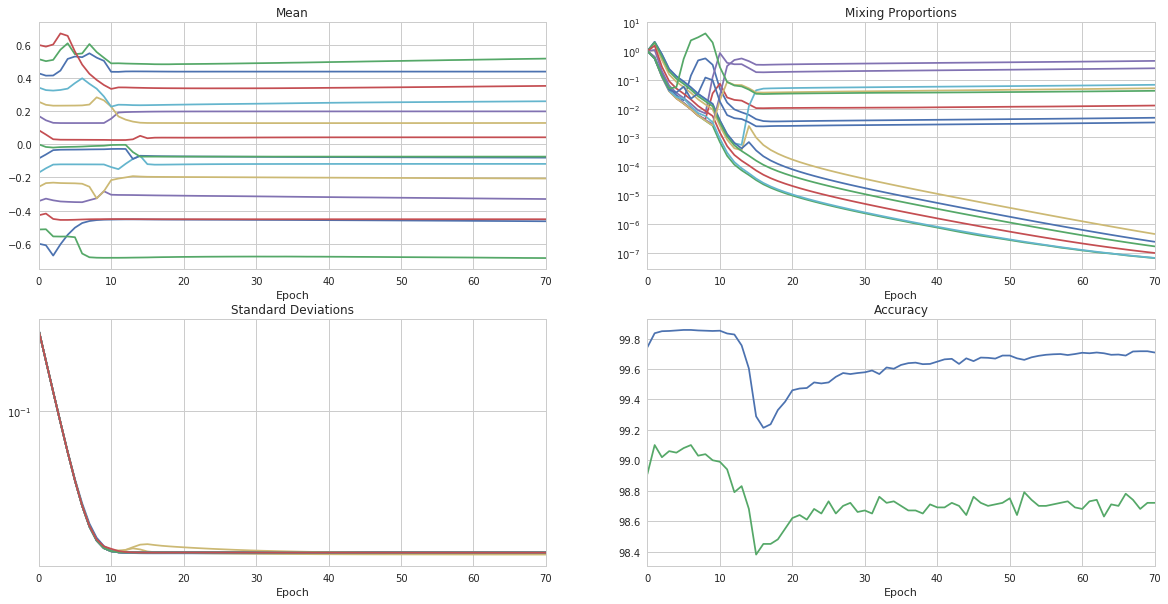

In [5]:
draw_sws_graphs(mean_history, stddev_history, mixprop_history, acc_history, exp_name)
images = []
filenames = ["figs/{}_{}.png".format(exp_name, x) for x in range(1,retraining_epochs+1)]
for filename in filenames:
    images.append(imageio.imread(filename))
imageio.mimsave('./exp/{}.gif'.format(exp_name), images)
torch.save(model_retrain, model_dir + 'mnist_retrain_{}.m'.format(exp_name))
with open(model_dir + 'mnist_retrain_{}.m'.format(exp_name),'wb') as f:
    pickle.dump(gmp, f)
ipd.HTML('<img src="./exp/{}.gif">'.format(exp_name))

In [9]:
images = []
filenames = ["figs/jp_{}_{}.png".format(exp_name, x) for x in range(1,retraining_epochs+1)]
for filename in filenames:
    images.append(imageio.imread(filename))
imageio.mimsave('./exp/jp_{}.gif'.format(exp_name), images)
ipd.HTML('<img src="./exp/jp_{}.gif">'.format(exp_name))

### 3. Prune Model

In [26]:
import sws_utils

In [29]:
import importlib
importlib.reload(sws_utils)

<module 'sws_utils' from '/home/okz21/NNC/NN_compression/sws_utils.py'>

In [37]:
print (test_accuracy(test_data_full, test_labels_full, model))

(98.91, 1.4718830585479736)


In [38]:
print (test_accuracy(test_data_full, test_labels_full, model_retrain))

(98.75, 1.4772148132324219)


(98.58, 1.4843623638153076)


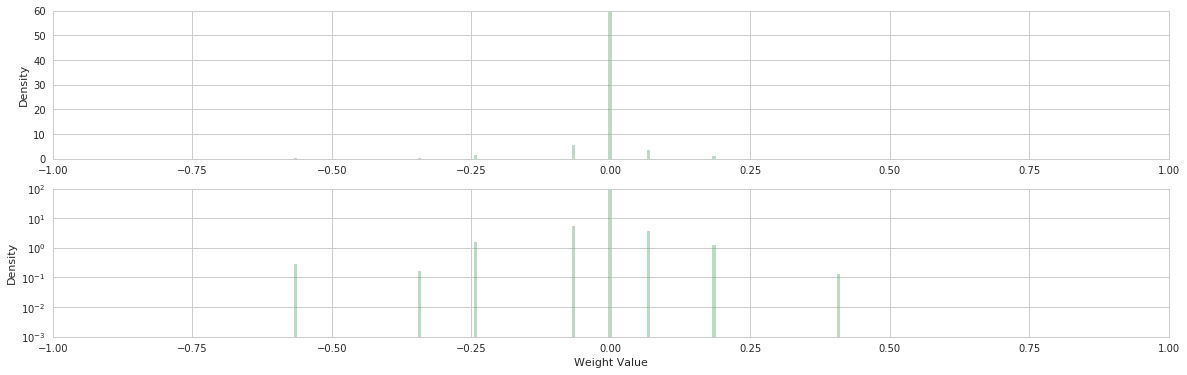

In [32]:
model_prune = copy.deepcopy(model_retrain)
model_prune.load_state_dict(sws_utils.sws_prune(model_prune, gmp))
print (test_accuracy(test_data_full, test_labels_full, model_prune))
show_sws_weights(model_prune)

In [36]:
(special_flatten(model_prune.state_dict())==0).sum()/642460.0

0.9256576284904897